<a href="https://colab.research.google.com/github/miadibe/CASA0004/blob/master/01_FloorClassification_Fastai_Site.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **FLOOR CLASSIFIER - SITE IMAGES**

In [ ]:
# Code Inspired by Luo, D. 2018: Classify Building Conditions in Zanzibar from Drone Imagery
# https://github.com/daveluo/zanzibar-aerial-mapping/blob/master/archive/znz-classify-buildings-20190118.ipynb
# and Fastai Image Classification
# https://github.com/fastai/course-v3/blob/master/nbs/dl1/lesson1-pets.ipynb

**1- LOAD LIBRARIES**

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from fastai import *
from fastai.vision import *

In [3]:
from fastai.utils import *
show_install()



```text
=== Software === 
python        : 3.6.9
fastai        : 1.0.61
fastprogress  : 0.2.5
torch         : 1.6.0+cu101
nvidia driver : 418.67
torch cuda    : 10.1 / is available
torch cudnn   : 7603 / is enabled

=== Hardware === 
nvidia gpus   : 1
torch devices : 1
  - gpu0      : 15079MB | Tesla T4

=== Environment === 
platform      : Linux-4.19.112+-x86_64-with-Ubuntu-18.04-bionic
distro        : #1 SMP Thu Jul 23 08:00:38 PDT 2020
conda env     : Unknown
python        : /usr/bin/python3
sys.path      : 
/env/python
/usr/lib/python36.zip
/usr/lib/python3.6
/usr/lib/python3.6/lib-dynload
/usr/local/lib/python3.6/dist-packages
/usr/lib/python3/dist-packages
/usr/local/lib/python3.6/dist-packages/IPython/extensions
/root/.ipython
```

Please make sure to include opening/closing ``` when you paste into forums/github to make the reports appear formatted as code sections.

Optional package(s) to enhance the diagnostics can be installed with:
pip install distro
Once installed, re-run 

**2- LOAD DATA CLONED FROM GITHUB PRIVATE REPO**

In [4]:
u = 'username';
p = 'password'; 
!git clone https://$u:$p@github.com/$u/AEC-Demo.git

Cloning into 'AEC-Demo'...
remote: Enumerating objects: 260, done.
remote: Counting objects: 100% (260/260), done.
remote: Compressing objects: 100% (245/245), done.
remote: Total 6957 (delta 16), reused 254 (delta 14), pack-reused 6697
Receiving objects: 100% (6957/6957), 13.76 GiB | 41.39 MiB/s, done.
Resolving deltas: 100% (111/111), done.
Checking out files: 100% (9175/9175), done.


In [5]:
# Add this line to prevent future warning messages 
import warnings
warnings.filterwarnings("ignore", category=UserWarning, module="torch.nn.functional")

In [6]:
path = Path('/content/AEC-Demo')

In [7]:
path_img = path/'camera'

In [8]:
fnames = get_image_files(path_img)
print(len(fnames))
fnames[:5]

4652


[PosixPath('/content/AEC-Demo/camera/2006181430008486_12-floors.jpg'),
 PosixPath('/content/AEC-Demo/camera/2001071745008607_9-floors.jpg'),
 PosixPath('/content/AEC-Demo/camera/1911061245004757_5-floors.jpg'),
 PosixPath('/content/AEC-Demo/camera/1911051330004711_5-floors.jpg'),
 PosixPath('/content/AEC-Demo/camera/1912111830006971_8-floors.jpg')]

**2- PREPROCESS DATA**

In [9]:
# Filter out empty .jpg files by size>0 and sort
fnames = [fname.name for fname in sorted(fnames) if os.path.getsize(fname)>0]
print(len(fnames))
fnames[:5]

4652


['1810101155080695_0-floor.jpg',
 '1810101200000696_0-floor.jpg',
 '1810101215000697_0-floor.jpg',
 '1812251100005328_0-floor.jpg',
 '1812251115005329_0-floor.jpg']

In [10]:
#Store data in table using Pandas

df = pd.DataFrame(fnames,columns=['fnames'])
df.head()

fnames
0  1810101155080695_0-floor.jpg
1  1810101200000696_0-floor.jpg
2  1810101215000697_0-floor.jpg
3  1812251100005328_0-floor.jpg
4  1812251115005329_0-floor.jpg

In [11]:
# Hand-picked validation images
# Used for validation set which the model does not get to look at when training
# To avoid overfitting
holdout_grids = ['1810','1811','1812']
valid_idx = [i for i,o in df.iterrows() if any(c in str(o.fnames) for c in holdout_grids)]

In [12]:
df.iloc[valid_idx].head()

fnames
0  1810101155080695_0-floor.jpg
1  1810101200000696_0-floor.jpg
2  1810101215000697_0-floor.jpg
3  1812251100005328_0-floor.jpg
4  1812251115005329_0-floor.jpg

**4- LABELS EXTRACTION**

In [13]:
# Pulled out of fastai/data.py
# Use Python Regular expressions to retrieve labels out of filenames
pat = r'([^_]+).jpg$'
pat = re.compile(pat)
def get_label(fn): return pat.search(str(fn)).group(1)

In [14]:
src = (ImageList.from_df(df, folder='camera', path=path)
        .split_by_idx(valid_idx)
        .label_from_func(get_label, classes=['0-floor', '1-floor', '2-floors', '3-floors',
                                             '4-floors','5-floors','6-floors','7-floors','8-floors',
                                             '9-floors','10-floors','11-floors','12-floors','13-floors',
                                             '14-floors','15-floors']))

In [37]:
# Batch size: the higher the more accurate the model. 
# Start with 64 and reduce down to 2 if model throws GPU-related error
# It determines the number of image bunch to process at a time
bs = 8

# Image size: resize all images to 224 x 224 px and reduce down to 64 if model throws GPU-related error. 
sz = 64

# Data Augmentation: Flipping vertically, rotating, warpping, zooming, brightening
tfms = get_transforms(flip_vert=True, max_rotate=0.2, max_warp=0., max_zoom=1.1, max_lighting=0.4)

#Normalize all images to same mean and standard devation according to pretrained ImageNet (imagenet_stats) dataset
data = (src.transform(tfms, size=sz, resize_method=ResizeMethod.SQUISH, padding_mode='zeros')
        .databunch(bs=bs)
        .normalize(imagenet_stats))

In [38]:
data

ImageDataBunch;

Train: LabelList (4550 items)
x: ImageList
Image (3, 64, 64),Image (3, 64, 64),Image (3, 64, 64),Image (3, 64, 64),Image (3, 64, 64)
y: CategoryList
0-floor,0-floor,0-floor,0-floor,0-floor
Path: /content/AEC-Demo;

Valid: LabelList (102 items)
x: ImageList
Image (3, 64, 64),Image (3, 64, 64),Image (3, 64, 64),Image (3, 64, 64),Image (3, 64, 64)
y: CategoryList
0-floor,0-floor,0-floor,0-floor,0-floor
Path: /content/AEC-Demo;

Test: None

In [39]:
data.train_ds.classes

['0-floor',
 '1-floor',
 '2-floors',
 '3-floors',
 '4-floors',
 '5-floors',
 '6-floors',
 '7-floors',
 '8-floors',
 '9-floors',
 '10-floors',
 '11-floors',
 '12-floors',
 '13-floors',
 '14-floors',
 '15-floors']

0-floor /content/AEC-Demo/camera/1810101155080695_0-floor.jpg


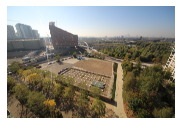

0-floor /content/AEC-Demo/camera/1810101200000696_0-floor.jpg


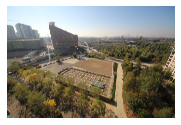

0-floor /content/AEC-Demo/camera/1810101215000697_0-floor.jpg


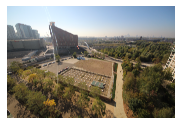

0-floor /content/AEC-Demo/camera/1812251100005328_0-floor.jpg


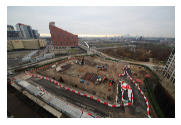

0-floor /content/AEC-Demo/camera/1812251115005329_0-floor.jpg


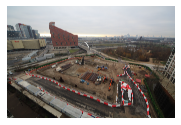

In [40]:
# Show first 5 images
for i in range(5):
    print(data.valid_ds.classes[data.valid_ds.y[i].data], data.valid_ds.items[i]); 
    data.valid_ds.x[i].show()
    plt.show()

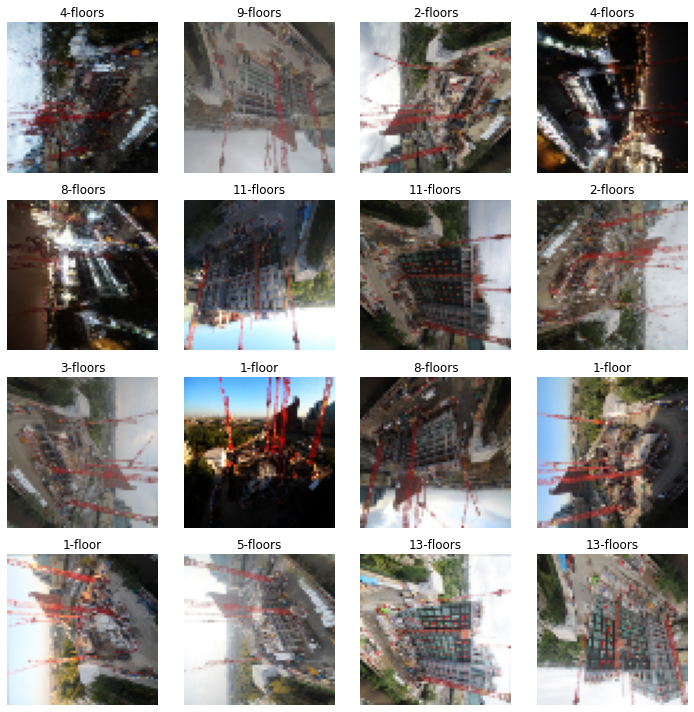

In [19]:
#Show random images 
data.show_batch(rows=4, figsize=(10,10))

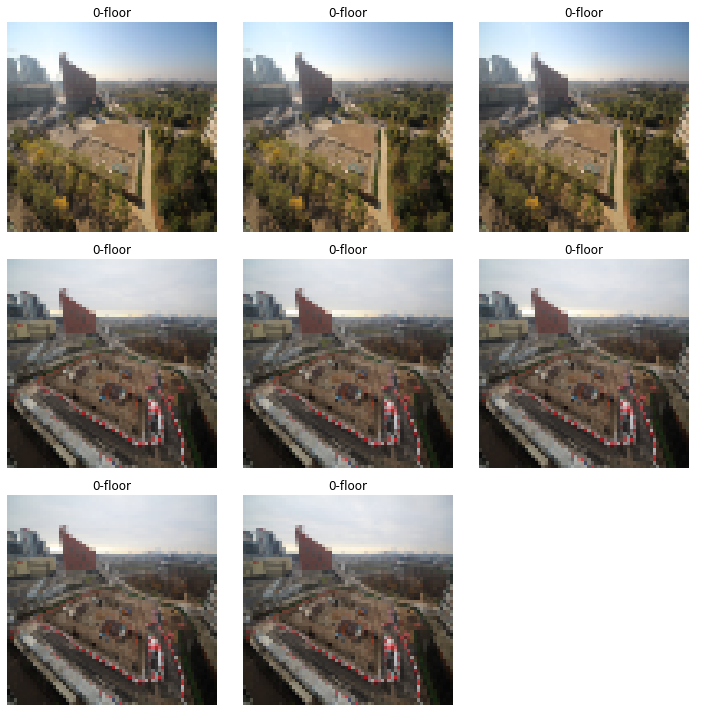

In [41]:
data.show_batch(rows=4, figsize=(10,10), ds_type=DatasetType.Valid)

In [42]:
# Cross Entropy Loss is the function for loss likelihood which penalises incorrect confident predictions and correct unconfident predictions (False positive & true negative)
data.loss_func

FlattenedLoss of CrossEntropyLoss()

In [44]:
#Create CNN model
learn = cnn_learner(data, models.resnet50, metrics=error_rate)

In [45]:
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


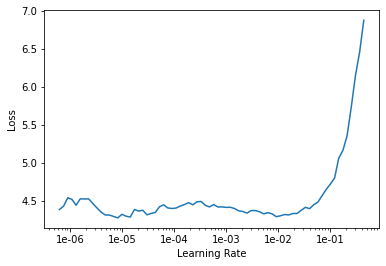

In [46]:
#Learning rate indicates how quickly we are updating the model. By default, trains all layers at the same speed

learn.lr_find()
learn.recorder.plot()

In [47]:
#Pick learning rate where loss is starting to drop
lr = 1e-3

In [48]:
## IGNORE THIS and run next line

from fastai.callbacks import *

# small change to SaveModelCallback() to add printouts
@dataclass
class SaveModelCallbackVerbose(TrackerCallback):
    "A `TrackerCallback` that saves the model when monitored quantity is best."
    every:str='improvement'
    name:str='bestmodel'
    def __post_init__(self):
        if self.every not in ['improvement', 'epoch']:
            warn(f'SaveModel every {self.every} is invalid, falling back to "improvement".')
            self.every = 'improvement'
        super().__post_init__()

    def on_epoch_end(self, epoch, **kwargs:Any)->None:
        if self.every=="epoch": self.learn.save(f'{self.name}_{epoch}')
        else: #every="improvement"
            current = self.get_monitor_value()
            if current is not None and self.operator(current, self.best):
                self.best = current
                self.learn.save(f'{self.name}')
                print(f'saved model at epoch {epoch} with {self.monitor} value: {current}')

    def on_train_end(self, **kwargs):
        if self.every=="improvement": self.learn.load(f'{self.name}')

In [35]:
!pip install -q git+https://github.com/fastai/fastprogress --upgrade
!pip install -q git+https://github.com/fastai/fastcore --upgrade
!pip install -q git+https://github.com/fastai/fastai2 --upgrade

In [49]:
#Run this line. Function that saves best model accuracy during training

class SaveBestModel(Recorder):
    def __init__(self, learn,name='best_model'):
        super().__init__(learn)
        self.name = name
        self.best_loss = None
        self.best_acc = None
        self.save_method = self.save_when_acc
        
    def save_when_acc(self, metrics):        
        loss, acc = metrics[0], metrics[1]
        if self.best_acc == None or acc > self.best_acc:
            self.best_acc = acc
            self.best_loss = loss
            self.learn.save(f'{self.name}')
            print("Save the best accuracy {:.5f}".format(self.best_acc))
        elif acc == self.best_acc and  loss < self.best_loss:
            self.best_loss = loss
            self.learn.save(f'{self.name}')
            print("Accuracy is eq,Save the lower loss {:.5f}".format(self.best_loss))
            
    def on_epoch_end(self,last_metrics=MetricsList,**kwargs:Any):
        self.save_method(last_metrics)

In [50]:
learn = cnn_learner(data, models.resnet50, metrics=accuracy, callback_fns=SaveBestModel)

In [51]:
# Ignore this. Only run if getting "Image truncated" error (likely if not enough GPU memory to process all image)

from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

In [52]:
# Train model for 10 epochs. Decrease this number if computing time is too slow. 

learn.fit_one_cycle(10, max_lr=lr)

Save the best accuracy 0.53922
Save the best accuracy 0.59804
Save the best accuracy 0.69608
Save the best accuracy 0.76471
Save the best accuracy 0.77451
Save the best accuracy 0.90196
Save the best accuracy 0.91176
Accuracy is eq,Save the lower loss 0.28249


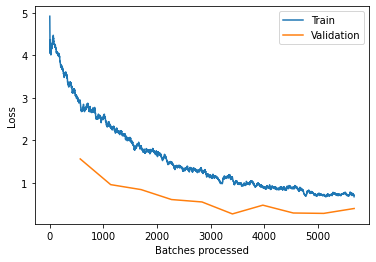

In [53]:
learn.recorder.plot_losses()

In [54]:
# What comes out of the training
interp = ClassificationInterpretation.from_learner(learn)

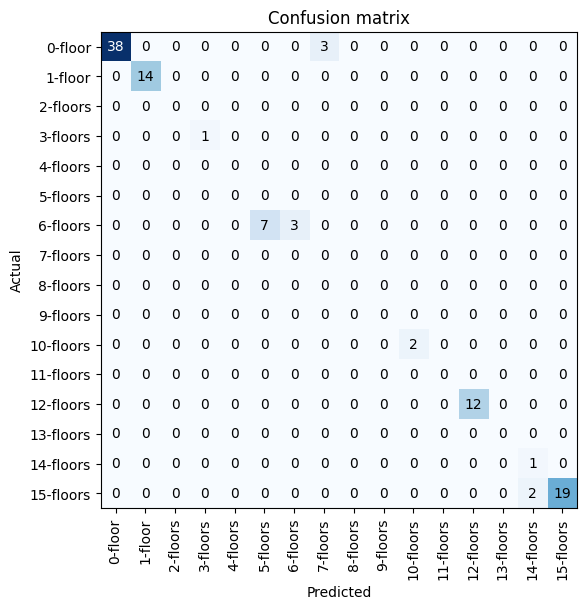

In [55]:
# How many floors were predicted wrong
interp.plot_confusion_matrix(figsize=(6,6), dpi=100)

In [56]:
# ('Should have predicted', 'predicted instead', 'how many times')
interp.most_confused(min_val=2)

[('6-floors', '5-floors', 7),
 ('0-floor', '7-floors', 3),
 ('15-floors', '14-floors', 2)]

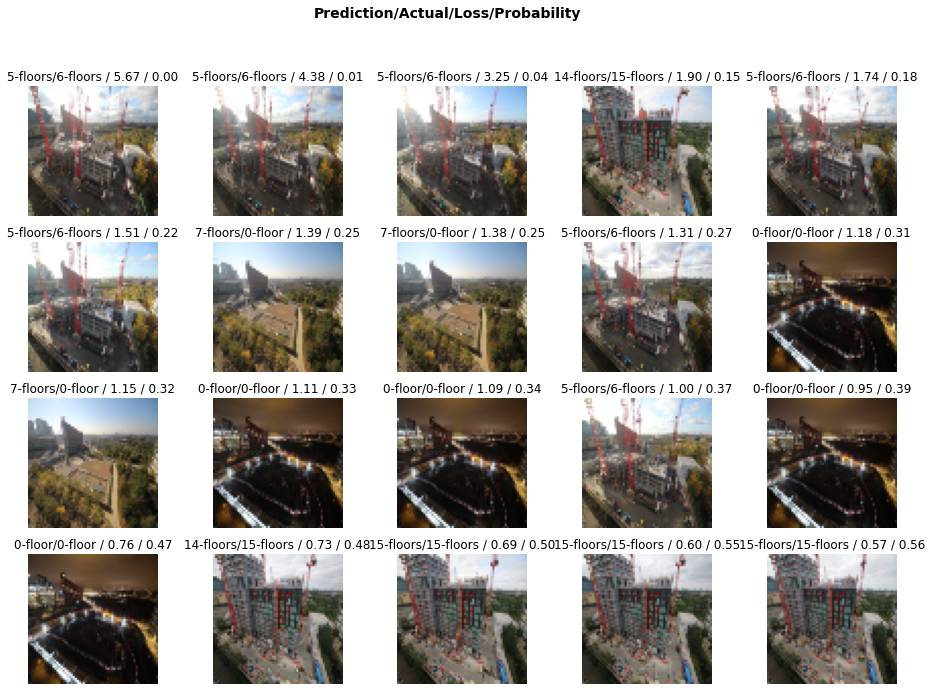

In [59]:
# Tells how good the prediction was for 25 images
predactual = interp.plot_top_losses(20, figsize=(16,11))

In [116]:
# STAGE 2
# Unfreeze() method trains the whole model, a way to fine-tuning the results above
# Freezing does not update the model accuracy (only the new layers), is faster in computing and uses less memory

learn.unfreeze()

In [117]:
learn.lr_find()
learn.recorder.plot()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


IndexError: ignored

In [ ]:
# Stage 2 of Training
# Use best saved model from above and slice learning rate to choose learning rate that is equally spread between first and last CNN layer
learn = cnn_learner(data, models.resnet50, metrics=accuracy, callback_fns=SaveBestModel)
learn.fit_one_cycle(5, max_lr=slice(3e-5,lr/5))

Save the best accuracy 0.52941


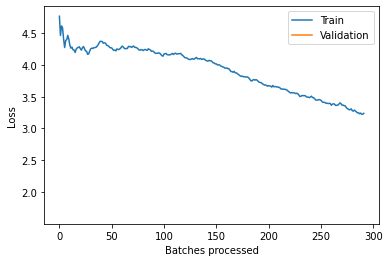

In [ ]:
learn.recorder.plot_losses()

**4- LOOK AT RESULTS**

In [ ]:
# What comes out of the training
interp = ClassificationInterpretation.from_learner(learn)

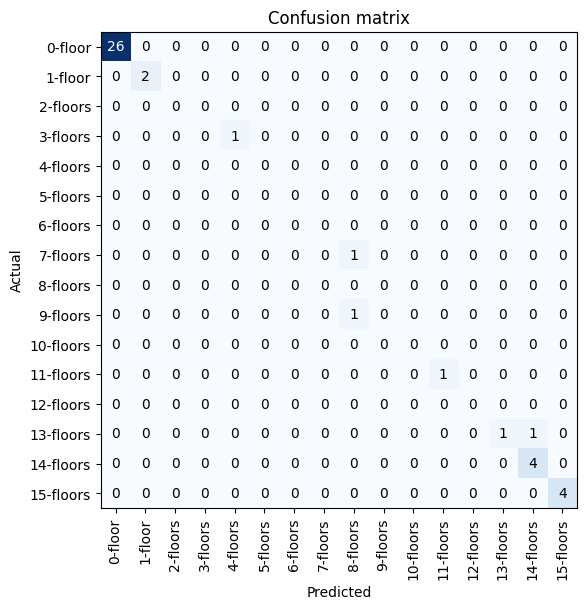

In [ ]:
# How many floors were predicted wrong
interp.plot_confusion_matrix(figsize=(6,6), dpi=100)

In [ ]:
# ('Should have predicted', 'predicted instead', 'how many times')
interp.most_confused(min_val=2)

[('12-floors', '13-floors', 10),
 ('15-floors', '12-floors', 7),
 ('15-floors', '14-floors', 6),
 ('0-floor', '1-floor', 4),
 ('6-floors', '5-floors', 4),
 ('15-floors', '10-floors', 3),
 ('15-floors', '13-floors', 3),
 ('0-floor', '7-floors', 2)]

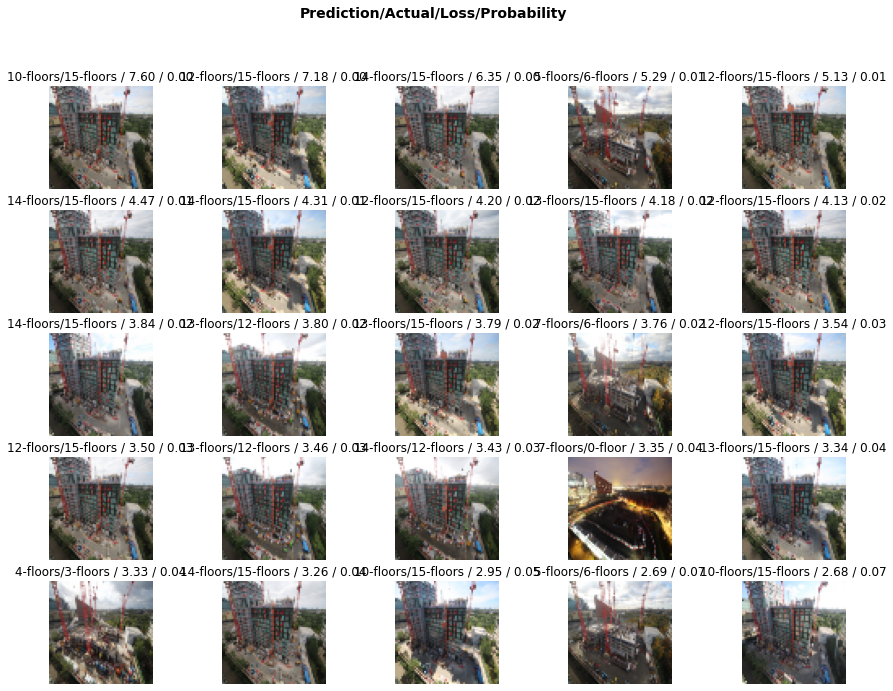

In [ ]:
# Tells how good the prediction was for 25 images
predactual = interp.plot_top_losses(25, figsize=(15,11))

**5- TEST TIME !**

In [60]:
data.classes

['0-floor',
 '1-floor',
 '2-floors',
 '3-floors',
 '4-floors',
 '5-floors',
 '6-floors',
 '7-floors',
 '8-floors',
 '9-floors',
 '10-floors',
 '11-floors',
 '12-floors',
 '13-floors',
 '14-floors',
 '15-floors']

In [61]:
#Reveal CNN Architecture 
learn.model.eval()

Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
          (0): Conv2d(64, 256

In [62]:
#Print number of test images 

test_path = Path(f'/content/AEC-Demo/test/test_camera')
test_fns = [o for o in sorted(test_path.iterdir()) if '.jpg' in o.name]
print(len(test_fns))

16


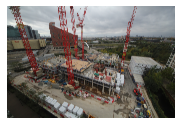

In [63]:
img = open_image(test_fns[10])
img.show()
plt.show()

In [64]:
#Tensor array for pixels prediction 
learn.predict(img)

(Category tensor(4),
 tensor(4),
 tensor([2.2338e-06, 1.0231e-05, 2.8114e-03, 1.1257e-02, 9.7082e-01, 1.2572e-02,
         2.3069e-03, 4.7824e-05, 1.0415e-04, 1.7702e-05, 1.9883e-05, 4.7771e-06,
         7.8659e-07, 1.7897e-06, 1.1519e-06, 1.8445e-05]))

In [65]:
from tqdm import tqdm

In [66]:
preds = []
pred_classes = []
for fn in tqdm(test_fns):
    try: 
        img = open_image(fn)
        img = img.apply_tfms(tfms[1],resize_method=ResizeMethod.SQUISH, padding_mode='zeros')
        pred_class,pred_idx,outputs = learn.predict(img)
        preds.append(list(to_np(outputs)))
        pred_classes.append(str(pred_class))
    except Exception as exc: 
        print(f'{exc}') 
        preds.append([-1,-1,-1,-1])
        pred_classes.append('error')

100%|██████████| 16/16 [00:09<00:00,  1.67it/s]


In [67]:
np.round(preds,2)

array([[0.8 , 0.09, 0.  , 0.  , ..., 0.01, 0.01, 0.01, 0.01],
       [0.  , 0.  , 0.  , 0.  , ..., 0.  , 0.  , 0.  , 0.  ],
       [0.  , 0.  , 0.  , 0.  , ..., 0.  , 0.  , 0.  , 0.  ],
       [0.  , 0.  , 0.  , 0.  , ..., 0.06, 0.  , 0.  , 0.  ],
       ...,
       [0.  , 0.  , 0.  , 0.02, ..., 0.  , 0.  , 0.  , 0.  ],
       [0.  , 0.  , 0.  , 0.  , ..., 0.  , 0.  , 0.  , 0.  ],
       [0.  , 0.  , 0.  , 0.  , ..., 0.  , 0.  , 0.  , 0.  ],
       [0.  , 0.  , 0.  , 0.  , ..., 0.  , 0.  , 0.  , 0.  ]], dtype=float32)

In [68]:
df = pd.DataFrame(data=preds, columns=data.classes)
df['fname'] = [o.name for o in test_fns[:len(preds)]]
df['predicted_class'] = pred_classes

In [69]:
#Print Confidence level (probabilities)
df.head(16)

0-floor       1-floor  ...           fname  predicted_class
0   8.029202e-01  9.088252e-02  ...   example0f.jpg          0-floor
1   1.729744e-05  4.528210e-06  ...  example10f.jpg        10-floors
2   1.024078e-04  1.174373e-04  ...  example11f.jpg         9-floors
3   1.271646e-05  1.828512e-04  ...  example12f.jpg        11-floors
4   3.384416e-06  5.658226e-05  ...  example13f.jpg        13-floors
5   2.058816e-06  3.619131e-06  ...  example14f.jpg        13-floors
6   6.987288e-07  1.199875e-08  ...  example15f.jpg        15-floors
7   3.810208e-03  9.960574e-01  ...   example1f.jpg          1-floor
8   9.177895e-07  2.550587e-06  ...   example2f.jpg         2-floors
9   1.638561e-04  7.648768e-03  ...   example3f.jpg         2-floors
10  2.233789e-06  1.023089e-05  ...   example4f.jpg         4-floors
11  9.636893e-06  5.330989e-04  ...   example5f.jpg         5-floors
12  2.101355e-06  3.574741e-04  ...   example6f.jpg         5-floors
13  9.133461e-05  2.114767e-04  ...   example7f.jpg         6-floors
14  1.166077e-04  3.569091e-05  ...   example8f.jpg         8-floors
15  6.508432e-05  1.149114e-03  ...   example9f.jpg         9-floors

[16 rows x 18 columns]

In [70]:
pred_classes[:5]

['0-floor', '10-floors', '9-floors', '11-floors', '13-floors']

0-floor category confidence: 0.8029201626777649


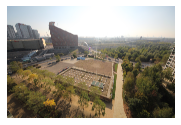

10-floors category confidence: 0.6301001906394958


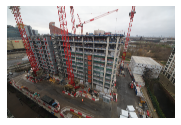

9-floors category confidence: 0.8420832753181458


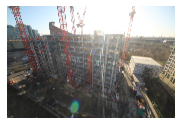

11-floors category confidence: 0.9340194463729858


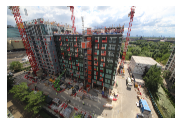

13-floors category confidence: 0.9391601085662842


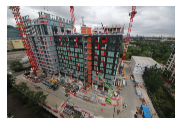

13-floors category confidence: 0.5379451513290405


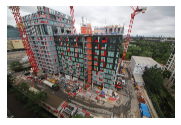

15-floors category confidence: 0.8309552669525146


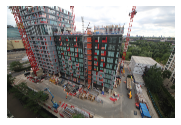

1-floor category confidence: 0.996057391166687


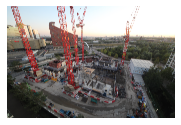

2-floors category confidence: 0.942419707775116


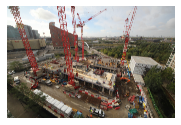

2-floors category confidence: 0.5045600533485413


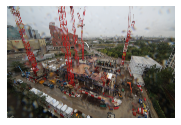

4-floors category confidence: 0.970824122428894


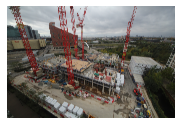

5-floors category confidence: 0.8554372787475586


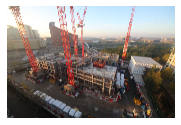

5-floors category confidence: 0.7282120585441589


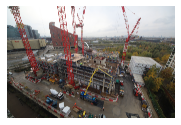

6-floors category confidence: 0.5201370716094971


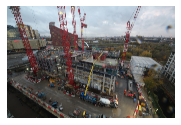

8-floors category confidence: 0.6784265637397766


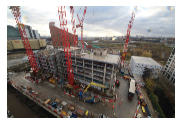

9-floors category confidence: 0.8331719636917114


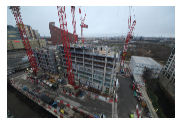

In [71]:
# Show results for 16 images 
for i in range(16):
    img = open_image(test_path/df.iloc[i]['fname'])
    print(df.iloc[i]['predicted_class'], 'category confidence:', df[df.iloc[i]['predicted_class']].iloc[i])
    img.show()
    plt.show()

In [73]:
# Save outputs to .csv
df.to_csv('/content/classif_site_predictions-stage01.csv',index=False)

**6- EXTRA: T-SNE VISUALISATION**

In [ ]:
# t-SNE Visualization (thanks to & adapted from @KarlH)
# https://forums.fast.ai/t/share-your-work-here/27676/53
# https://github.com/kheyer/ML-DL-Projects/blob/master/Pets%20TSNE/pets_tsne.ipynb

In [74]:
from sklearn.manifold import TSNE
import seaborn as sns
from sklearn import manifold, datasets
from sklearn.metrics.pairwise import pairwise_distances
from sklearn.metrics import confusion_matrix
from scipy.spatial.distance import squareform
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
from matplotlib.ticker import NullFormatter
import PIL

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [75]:
preds = interp.preds
y = interp.y_true
losses = interp.losses

In [76]:
probs_trans = manifold.TSNE(n_components=2, perplexity=15).fit_transform(preds)

In [77]:
prob_df = pd.DataFrame(np.concatenate((probs_trans, y[:,None]), axis=1), columns=['x','y','labels'])
prob_df.head()

x         y  labels
0 -2.770553  5.911339     0.0
1 -2.769990  5.926350     0.0
2 -2.744115  5.855831     0.0
3 -7.861376 -0.038325     0.0
4 -7.734344 -0.205814     0.0

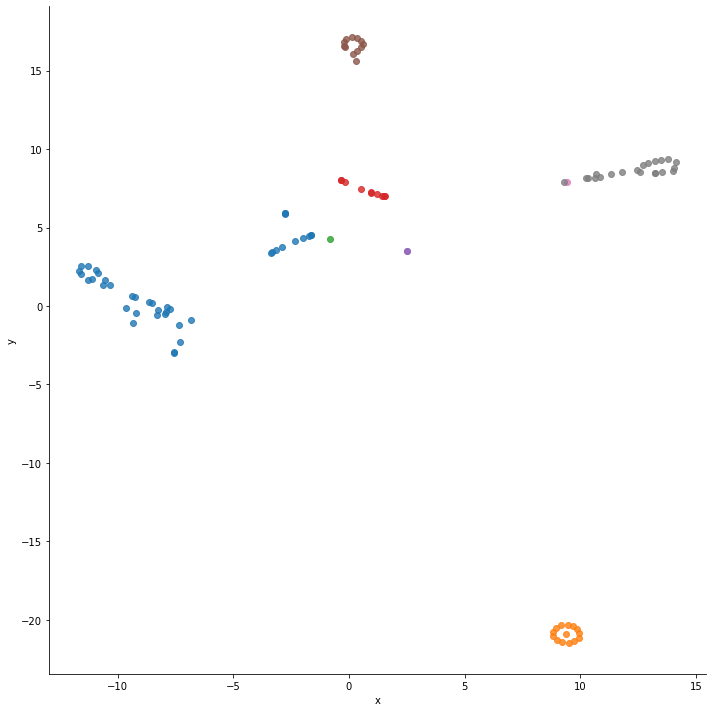

In [78]:
#Visualise top losses 
g = sns.lmplot('x', 'y', data=prob_df, hue='labels', fit_reg=False, legend=False, height=10)

In [79]:
prob_df['fname'] = data.valid_ds.items
prob_df['loss'] = losses
prob_df.head()

x  ...      loss
0 -2.770553  ...  1.384157
1 -2.769990  ...  1.386596
2 -2.744115  ...  1.151583
3 -7.861376  ...  0.001801
4 -7.734344  ...  0.001868

[5 rows x 5 columns]

In [80]:
#Export outputs to .csv
prob_df.to_csv('/content/t-SNE-stage01.csv')

In [81]:
# modified to optionally filter by idxs

def visualize_scatter_with_images(scaled_data, df, idxs, figsize=(64,64), image_zoom=1, suffix=1):
    scaled_data = scaled_data[idxs]
    df = df.iloc[idxs]

    fig, ax = plt.subplots(figsize=figsize)
    artists = []
    xx = (scaled_data[:,0])
    yy = (scaled_data[:,1])
    
    for (i,x,y) in zip(idxs,xx,yy):
        im = PIL.Image.open(df['fname'][i])
        im.thumbnail((64,64))
        img = OffsetImage(im, zoom=image_zoom, cmap='gray')
        ab = AnnotationBbox(img, (x, y), xycoords='data', frameon=False)
        artists.append(ax.add_artist(ab))
    ax.update_datalim(np.column_stack([xx,yy]))
    ax.autoscale()
    
#     fig.savefig(f'TSNE_{suffix}.jpg', bbox_inches = 'tight')
    return fig, ax

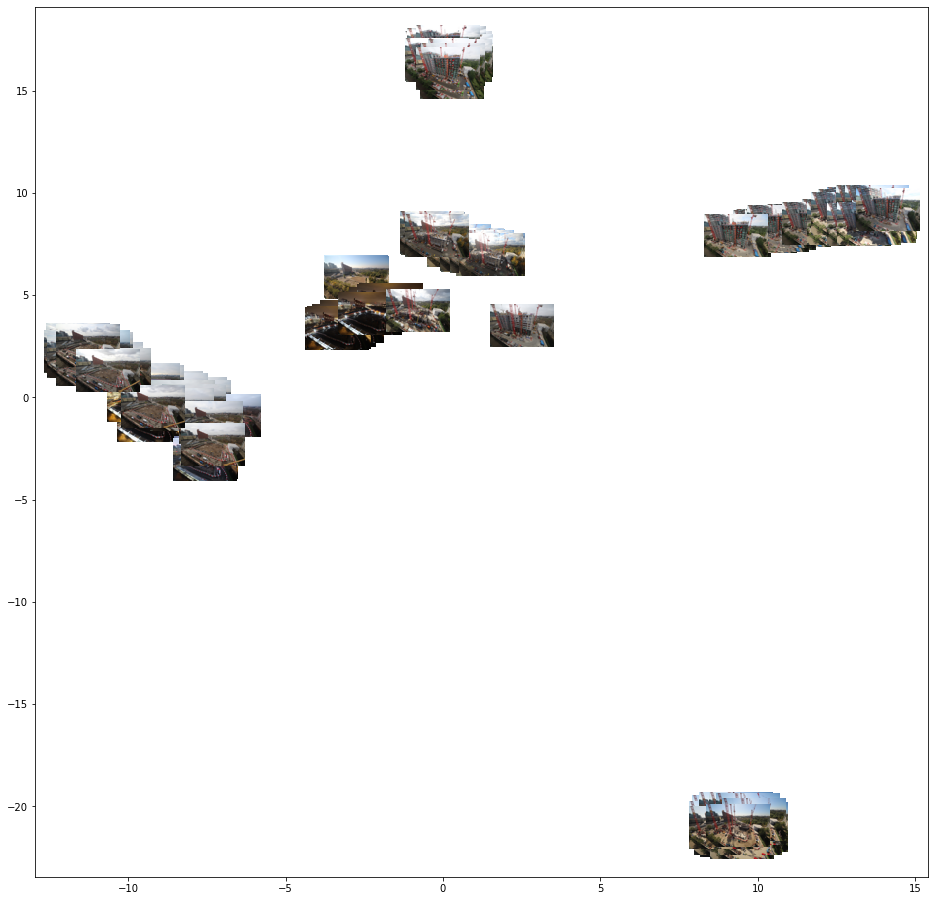

In [82]:
fig, ax = visualize_scatter_with_images(probs_trans, prob_df, range(len(prob_df)), figsize=(16,16), image_zoom=1, suffix='probabilities')
plt.show()

In [83]:
top_losses = prob_df['loss'].sort_values(ascending=False)[:20].index.values

In [84]:
toplossdf = prob_df.iloc[top_losses]
toplossdf

x  ...      loss
64   1.527353  ...  5.665860
59   1.575354  ...  4.380049
56   1.430612  ...  3.246577
91   9.304801  ...  1.899325
61   1.223209  ...  1.739552
57   0.938182  ...  1.509177
1   -2.769990  ...  1.386596
0   -2.770553  ...  1.384157
60   0.934939  ...  1.309219
19  -1.637971  ...  1.176640
2   -2.744115  ...  1.151583
20  -1.723963  ...  1.111860
17  -1.661791  ...  1.092655
58   0.505446  ...  0.997675
16  -1.973357  ...  0.946586
23  -2.314172  ...  0.758421
86  10.221260  ...  0.727358
83  10.314196  ...  0.687017
88  10.610612  ...  0.602842
89  10.683759  ...  0.572702

[20 rows x 5 columns]

In [85]:
toplossdf.to_csv('/content/top20-losses-stage01.csv')

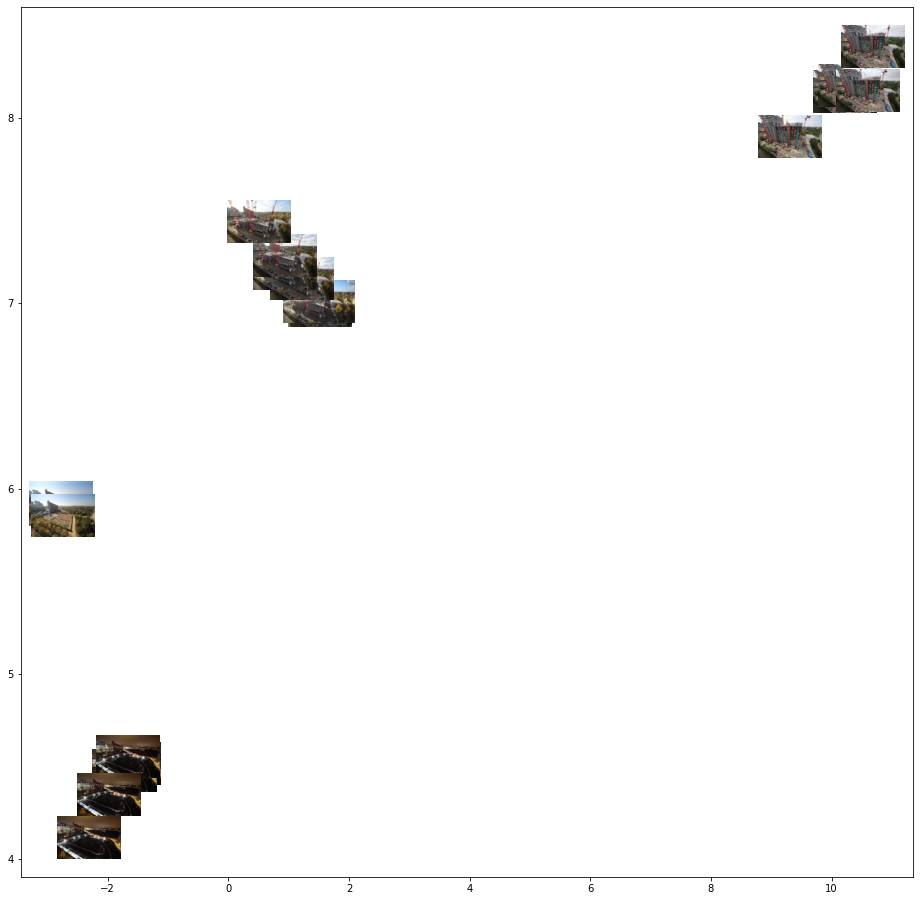

In [86]:
# Show only images with top 20 losses
fig, ax = visualize_scatter_with_images(probs_trans, prob_df, top_losses, figsize=(16,16),image_zoom=1, suffix='probabilities')
plt.show()

In [87]:
# Grad-CAM based on lesson6-pets-more

m = learn.model.eval()

Category 0

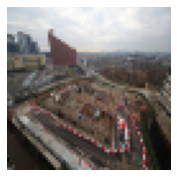

In [88]:
idx = 12
x,y = data.valid_ds[idx]
x.show()
data.valid_ds.y[idx]

In [89]:
xb, yb = data.one_item(x) # make batch with one item
xb_im = Image(data.denorm(xb)[0]) # denorm item into viewable image
xb = xb.cuda() # load on gpu

(None, torch.Size([1, 3, 64, 64]), torch.Size([1]))

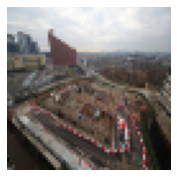

In [90]:
xb_im.show(), xb.shape, yb.shape

In [91]:
y, yb

(Category 0, tensor([0], device='cuda:0'))

In [92]:
from fastai.callbacks.hooks import *
import pdb

In [93]:
def hooked_backward(cat=y):
#     pdb.set_trace()
    with hook_output(m[0]) as hook_a: # set activation hook
        with hook_output(m[0], grad=True) as hook_g: # set gradient hook
            preds = m(xb) # forward pass
            preds[0,int(cat)].backward() # backward pass
    return hook_a, hook_g

In [94]:
hook_a, hook_g = hooked_backward()

In [95]:
acts = hook_a.stored[0].cpu()

In [96]:
acts.shape

torch.Size([2048, 2, 2])

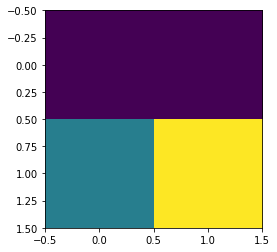

In [97]:
plt.imshow(acts[0])

In [98]:
avg_acts = acts.mean(0) # get the "pixel"-wise mean of activations (avg across 2018 channels)
avg_acts.shape

torch.Size([2, 2])

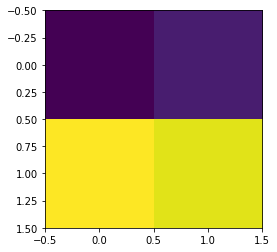

In [99]:
plt.imshow(avg_acts)

In [100]:
grad = hook_g.stored[0][0].cpu()

In [101]:
grad.shape

torch.Size([2048, 2, 2])

In [102]:
grad_chan = grad.mean(1).mean(1) # get the avg of grads for each channel
grad.shape, grad_chan.shape

(torch.Size([2048, 2, 2]), torch.Size([2048]))

In [103]:
grad_chan[...,None,None].shape # make 2 more axes to be same shape as acts

torch.Size([2048, 1, 1])

In [104]:
(acts*grad_chan[...,None,None]).mean(0).shape

torch.Size([2, 2])

In [105]:
mult = (acts*grad_chan[...,None,None]).mean(0)


In [106]:
def show_heatmap(hm,interpol='bilinear',cmap='magma'):
    _, ax = plt.subplots()
    xb_im.show(ax)
    ax.imshow(hm, alpha=0.6, extent=(0,512,512,0), interpolation=interpol,cmap=cmap)

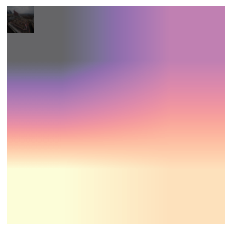

In [107]:
show_heatmap(mult)

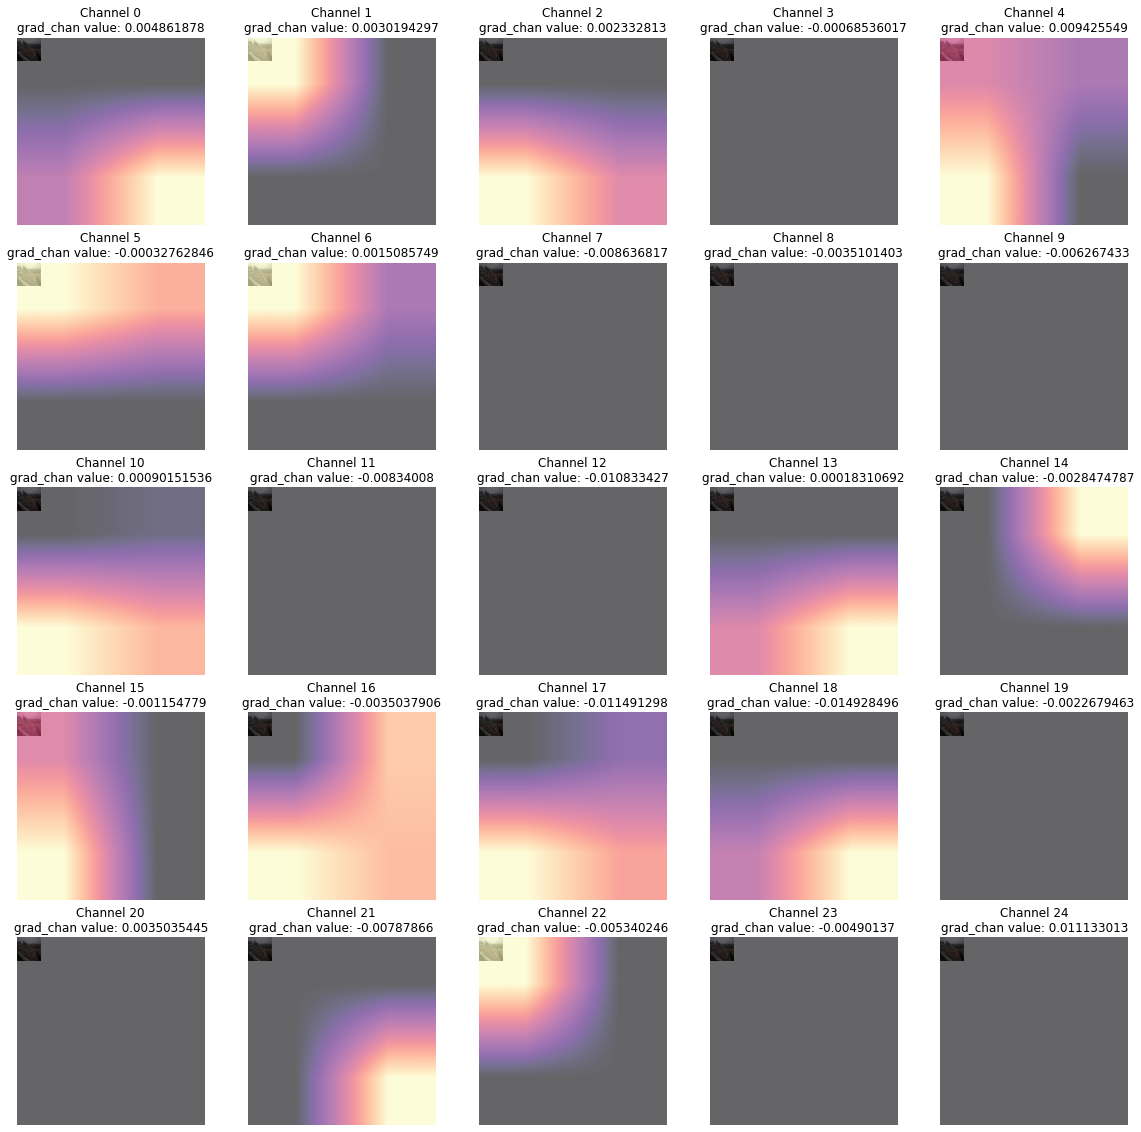

In [108]:
fig, axes = plt.subplots(5,5, figsize=(20,20))
for j, ax in enumerate(axes.flat):
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    xb_im.show(ax=ax)
    ax.set_title('Channel '+str(j)+ '\n'+'grad_chan value: '+str(grad_chan.numpy()[j]))
    ax.imshow(acts[j], alpha=0.6, extent=(0,512,512,0), interpolation='bilinear',cmap='magma')
#     ax.imshow([importance_idxs[j]]), alpha=0.6)
plt.show()

In [109]:
# thanks @henripal, from https://github.com/henripal/maps/blob/master/nbs/big_resnet50-interpret-gradcam-dogs.ipynb
import scipy.ndimage

def upsample(heatmap, zoom=32):
    upsampled = scipy.ndimage.zoom(heatmap, zoom)
    upsampled = (upsampled - np.min(upsampled))/((np.max(upsampled) - np.min(upsampled))+1e-16)
    return upsampled

In [110]:
grad_df = pd.DataFrame(grad_chan.numpy(), columns=['grad_chan'])
grad_df.head()

grad_chan
0   0.004862
1   0.003019
2   0.002333
3  -0.000685
4   0.009426

In [111]:
importance_idxs = grad_df.sort_values(by='grad_chan',ascending=False).index.values
importance_idxs

array([2015, 1690,  689,  900, ..., 1280,  361,   94, 1818])

In [112]:
grad_df.iloc[importance_idxs].head()

grad_chan
2015   0.048688
1690   0.047699
689    0.035850
900    0.034642
1548   0.034361

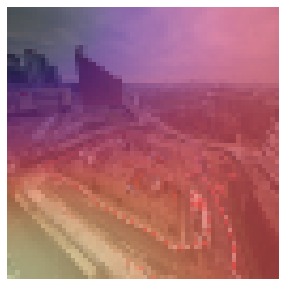

In [113]:
# heatmap with most important 100 activations (ranked by grad_chan)
fm_up = [upsample(fm) for fm in acts[importance_idxs[:100]]]
xb_im.show(figsize=(5,5))
plt.imshow(np.mean(fm_up, axis=0),alpha=0.6, cmap='magma')

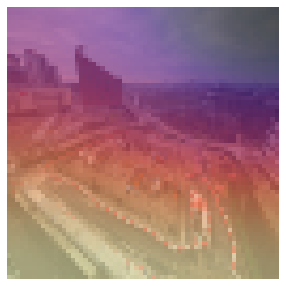

In [114]:
# heatmap with least important 100 activations (ranked by grad_chan)
fm_up = [upsample(fm) for fm in acts[importance_idxs[-100:]]]
xb_im.show(figsize=(5,5))
plt.imshow(np.mean(fm_up, axis=0),alpha=0.6, cmap='magma')

In [ ]:
## end